In [413]:
%load_ext autoreload
%autoreload 2

##  we're using the following packages:
#   msapy == 0.1.1
#   netneurotools == 0.2.3
#   numpy == 1.20.3
#   numba == 0.54.1
#   pandas == 1.3.5
#   bctpy == 0.5.2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [414]:
import netneurotools.datasets
import numpy as np
from msapy import msa, plottings as pl
import matplotlib.pyplot as plt
import networkx as nx
import seaborn as sns
import utils as ut
from copy import deepcopy
import pandas as pd
from numba import njit

from netneurotools.metrics import communicability_wei, communicability_bin

SEED = 2023
pl.set_style(font_size=8)
my_colors = ['#006685', '#3FA5C4', '#FFFFFF', '#E84653', '#BF003F']
my_reds = ['#FFFFFF', '#E84653', '#BF003F']
my_blues = ['#FFFFFF', '#3FA5C4', '#006685']
moreblue = sns.blend_palette(['#3FA5C4', '#006685'],as_cmap=True)
colormap = sns.blend_palette(my_colors,as_cmap=True)
redmap = sns.blend_palette(my_reds,as_cmap=True)
bluemap = sns.blend_palette(my_blues,as_cmap=True)

sagittal=(0, 180)
axial=(90, 180)
coronal=(0, 90)
bottom=(-90,0)

In [415]:
@njit
def simple_dynamical_system(adjacency_matrix,input_matrix):
    X = np.zeros((input_matrix.shape[0], input_matrix.shape[1]))

    for timepoint in range(input_matrix.shape[1] - 1):
        X[:, timepoint + 1] = np.tanh(adjacency_matrix @ X[:, timepoint] + input_matrix[:,timepoint])

    return X

@njit
def simple_linear_dynamical_system(adjacency_matrix,input_matrix):
    X = np.zeros((input_matrix.shape[0], input_matrix.shape[1]))

    for timepoint in range(input_matrix.shape[1] - 1):
        X[:, timepoint + 1] = adjacency_matrix @ X[:, timepoint] + input_matrix[:,timepoint]

    return X

def find_density(connectivity):
    return np.where(connectivity!=0,1,0).sum()/connectivity.shape[0]**2

def normer(x):
    return (x - x.min()) / (x.max() - x.min())

def spectral_normalization(target_radius,connectivity):
    return connectivity * target_radius/(np.max(np.abs(np.linalg.eigvals(connectivity))))

def threshold(lower_threshold,connectivity):
    connectivity = pd.DataFrame(connectivity)
    connectivity = connectivity.fillna(0)
    lower = np.percentile(connectivity, lower_threshold)
    upper = np.percentile(connectivity, 100-lower_threshold)
    connectivity[(connectivity < upper) & (connectivity > lower)] = 0.
    return connectivity

def event_maker(n_units, timesteps,probability=1):
    if probability < 1:
        input = rng.choice([0,1],p=[1-probability,probability],size=(n_units,timesteps))
        input = input.astype(float)
    else:
        input = np.zeros((n_units,timesteps))
        for node in range(n_units):
            event_timepoints = rng.integers(0,timesteps,1)
            input[node,event_timepoints] += 1
    
    return input

def brain_plotter(data,coordinates,axis,view=(90,180),size=20,cmap='viridis',scatter_kwargs=None):

    axis.scatter(coordinates[:,0],coordinates[:,1],coordinates[:,2],c=data,cmap=cmap,s=size,**scatter_kwargs)
    axis.view_init(*view)
    axis.axis('off')
    scaling = np.array([axis.get_xlim(),
                    axis.get_ylim(),
                    axis.get_zlim()])
    axis.set_box_aspect(tuple(scaling[:, 1]/2 - scaling[:, 0]))
    return axis

def make_influence_ratio(difference_matrix,axis=0):
    positives=(difference_matrix>0).sum(axis)/len(difference_matrix)
    negatives=(difference_matrix<0).sum(axis)/len(difference_matrix)
    return(positives-negatives)

In [416]:
def lesion_simple_nodes(complements, network, index,input):

    lesioned_network = deepcopy(network)
    for target in complements:
        lesioned_network[:,target] = 0.0
        lesioned_network[target,:] = 0.0

    dynamics = simple_linear_dynamical_system(lesioned_network,input)
    lesioned_signal = dynamics[index,:]
    return lesioned_signal

In [417]:
rng = np.random.default_rng(seed=SEED)
chain = nx.to_numpy_array(nx.generators.path_graph(6,nx.DiGraph())).T


closedchain = chain.copy()
closedchain[0,5]=1
closedchain = spectral_normalization(0.9,closedchain)

chain *= 0.9

symmetricchain = nx.to_numpy_array(nx.generators.path_graph(6))
symmetricchain = spectral_normalization(0.9,symmetricchain)

timesteps = 100
example_input = event_maker(6,timesteps)




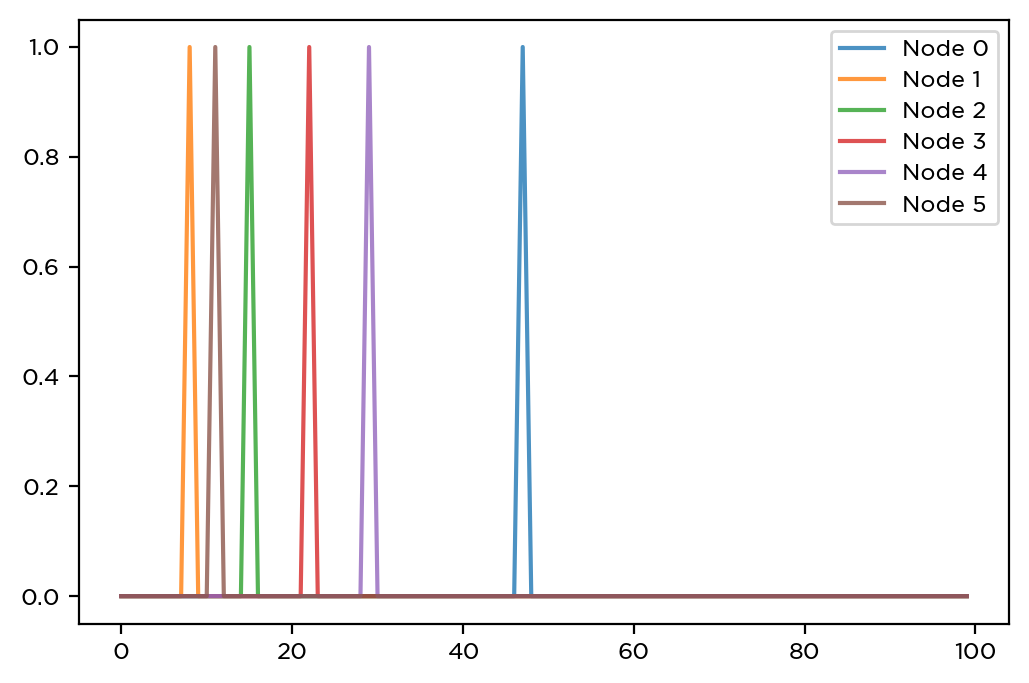

In [418]:
plt.figure(dpi=200)
plt.plot(example_input.T,alpha=0.8)
plt.legend(['Node 0','Node 1','Node 2','Node 3','Node 4','Node 5']);

In [419]:
simple_chain_dynamics = simple_linear_dynamical_system(chain,example_input)
closed_chain_dynamics = simple_linear_dynamical_system(closedchain,example_input)
symmetric_chain_dynamics = simple_linear_dynamical_system(symmetricchain,example_input)

/tmp/ipykernel_9311/2929560332.py:15: NumbaPerformanceWarning: '@' is faster on contiguous arrays, called on (array(float64, 2d, F), array(float64, 1d, A))
  X[:, timepoint + 1] = adjacency_matrix @ X[:, timepoint] + input_matrix[:,timepoint]
/home/kayson/anaconda3/envs/cmodes/lib/python3.9/site-packages/numba/core/typing/npydecl.py:965: NumbaPerformanceWarning: '@' is faster on contiguous arrays, called on (array(float64, 2d, F), array(float64, 1d, A))
  warnings.warn(NumbaPerformanceWarning(msg))
/tmp/ipykernel_9311/2929560332.py:15: NumbaPerformanceWarning: '@' is faster on contiguous arrays, called on (array(float64, 2d, C), array(float64, 1d, A))
  X[:, timepoint + 1] = adjacency_matrix @ X[:, timepoint] + input_matrix[:,timepoint]
/home/kayson/anaconda3/envs/cmodes/lib/python3.9/site-packages/numba/core/typing/npydecl.py:965: NumbaPerformanceWarning: '@' is faster on contiguous arrays, called on (array(float64, 2d, C), array(float64, 1d, A))
  warnings.warn(NumbaPerformanceWarnin

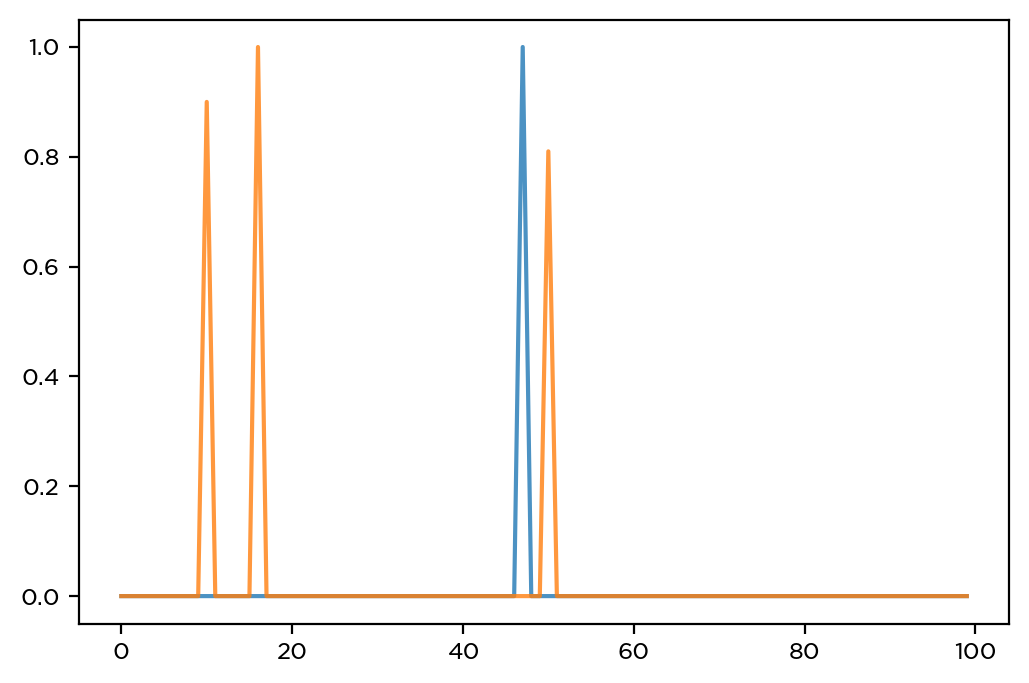

In [420]:
plt.figure(dpi=200)
plt.plot(example_input[0],alpha=0.8)
plt.plot(simple_chain_dynamics[2],alpha=0.8)

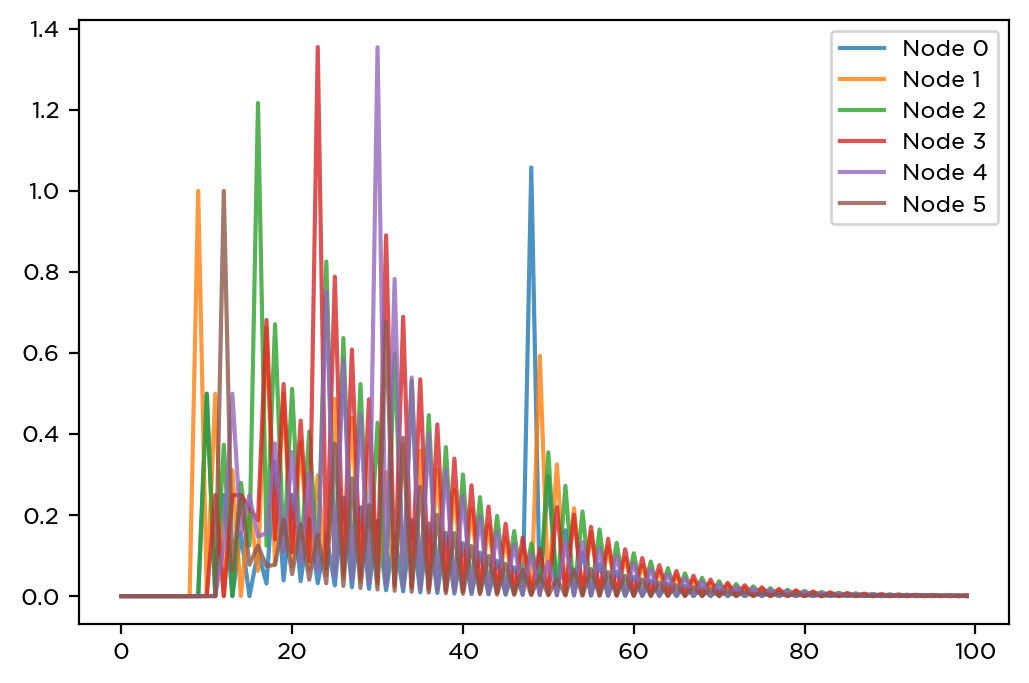

In [421]:
plt.figure(dpi=200)
plt.plot(symmetric_chain_dynamics.T,alpha=0.8)
plt.legend(['Node 0','Node 1','Node 2','Node 3','Node 4','Node 5'])

In [422]:
cchain= communicability_bin(chain)
cchain[np.diag_indices_from(cchain)] = 0

ccchain= communicability_bin(closedchain)
ccchain[np.diag_indices_from(cchain)] = 0

csychain= communicability_bin(symmetricchain)
csychain[np.diag_indices_from(cchain)] = 0


In [423]:
lesion_params = {'network': chain, 'input': example_input}
ci_chain = msa.estimate_causal_influences(elements=list(range(len(chain))),
                                        objective_function=lesion_simple_nodes,
                                        objective_function_params=lesion_params,
                                        n_permutations=1_000, n_cores=1)

lesion_params['network'] = closedchain
ci_closed_chain = msa.estimate_causal_influences(elements=list(range(len(chain))),
                                        objective_function=lesion_simple_nodes,
                                        objective_function_params=lesion_params,
                                        n_permutations=1_000, n_cores=1)

lesion_params['network'] = symmetricchain
ci_symmetric_chain = msa.estimate_causal_influences(elements=list(range(len(chain))),
                                        objective_function=lesion_simple_nodes,
                                        objective_function_params=lesion_params,
                                        n_permutations=1_000, n_cores=1)

ci_chain = ci_chain.groupby(level=0).var().fillna(0)
ci_closed_chain = ci_closed_chain.groupby(level=0).var().fillna(0)
ci_symmetric_chain = ci_symmetric_chain.groupby(level=0).var().fillna(0)

0it [00:00, ?it/s]

working on node number 0 from 6 nodes.


100%|██████████| 32/32 [00:00<00:00, 22362.17it/s]


working on node number 1 from 6 nodes.


100%|██████████| 32/32 [00:00<00:00, 21070.29it/s]
2it [00:00, 12.75it/s]

working on node number 2 from 6 nodes.


100%|██████████| 32/32 [00:00<00:00, 21495.47it/s]


working on node number 3 from 6 nodes.


100%|██████████| 32/32 [00:00<00:00, 22595.58it/s]
4it [00:00, 13.24it/s]

working on node number 4 from 6 nodes.


100%|██████████| 32/32 [00:00<00:00, 22313.84it/s]


working on node number 5 from 6 nodes.


100%|██████████| 32/32 [00:00<00:00, 22546.23it/s]
6it [00:00, 12.93it/s]
0it [00:00, ?it/s]

working on node number 0 from 6 nodes.


100%|██████████| 32/32 [00:00<00:00, 6456.50it/s]


working on node number 1 from 6 nodes.


100%|██████████| 32/32 [00:00<00:00, 18093.52it/s]
2it [00:00, 12.00it/s]

working on node number 2 from 6 nodes.


100%|██████████| 32/32 [00:00<00:00, 14430.46it/s]


working on node number 3 from 6 nodes.


100%|██████████| 32/32 [00:00<00:00, 15864.98it/s]
4it [00:00, 13.23it/s]

working on node number 4 from 6 nodes.


100%|██████████| 32/32 [00:00<00:00, 4405.20it/s]


working on node number 5 from 6 nodes.


100%|██████████| 32/32 [00:00<00:00, 23200.99it/s]
6it [00:00, 13.52it/s]
0it [00:00, ?it/s]

working on node number 0 from 6 nodes.


100%|██████████| 32/32 [00:00<00:00, 24192.09it/s]


working on node number 1 from 6 nodes.


100%|██████████| 32/32 [00:00<00:00, 24027.52it/s]
2it [00:00, 16.71it/s]

working on node number 2 from 6 nodes.


100%|██████████| 32/32 [00:00<00:00, 24231.40it/s]


working on node number 3 from 6 nodes.


100%|██████████| 32/32 [00:00<00:00, 13332.45it/s]
4it [00:00, 16.76it/s]

working on node number 4 from 6 nodes.


100%|██████████| 32/32 [00:00<00:00, 17198.58it/s]


working on node number 5 from 6 nodes.


100%|██████████| 32/32 [00:00<00:00, 8655.30it/s]
6it [00:00, 15.91it/s]


In [424]:
chain_mask = np.where(cchain!=0,1,0)
closedchain_mask = np.where(ccchain!=0,1,0)
symmetricchain_mask = np.where(csychain!=0,1,0)

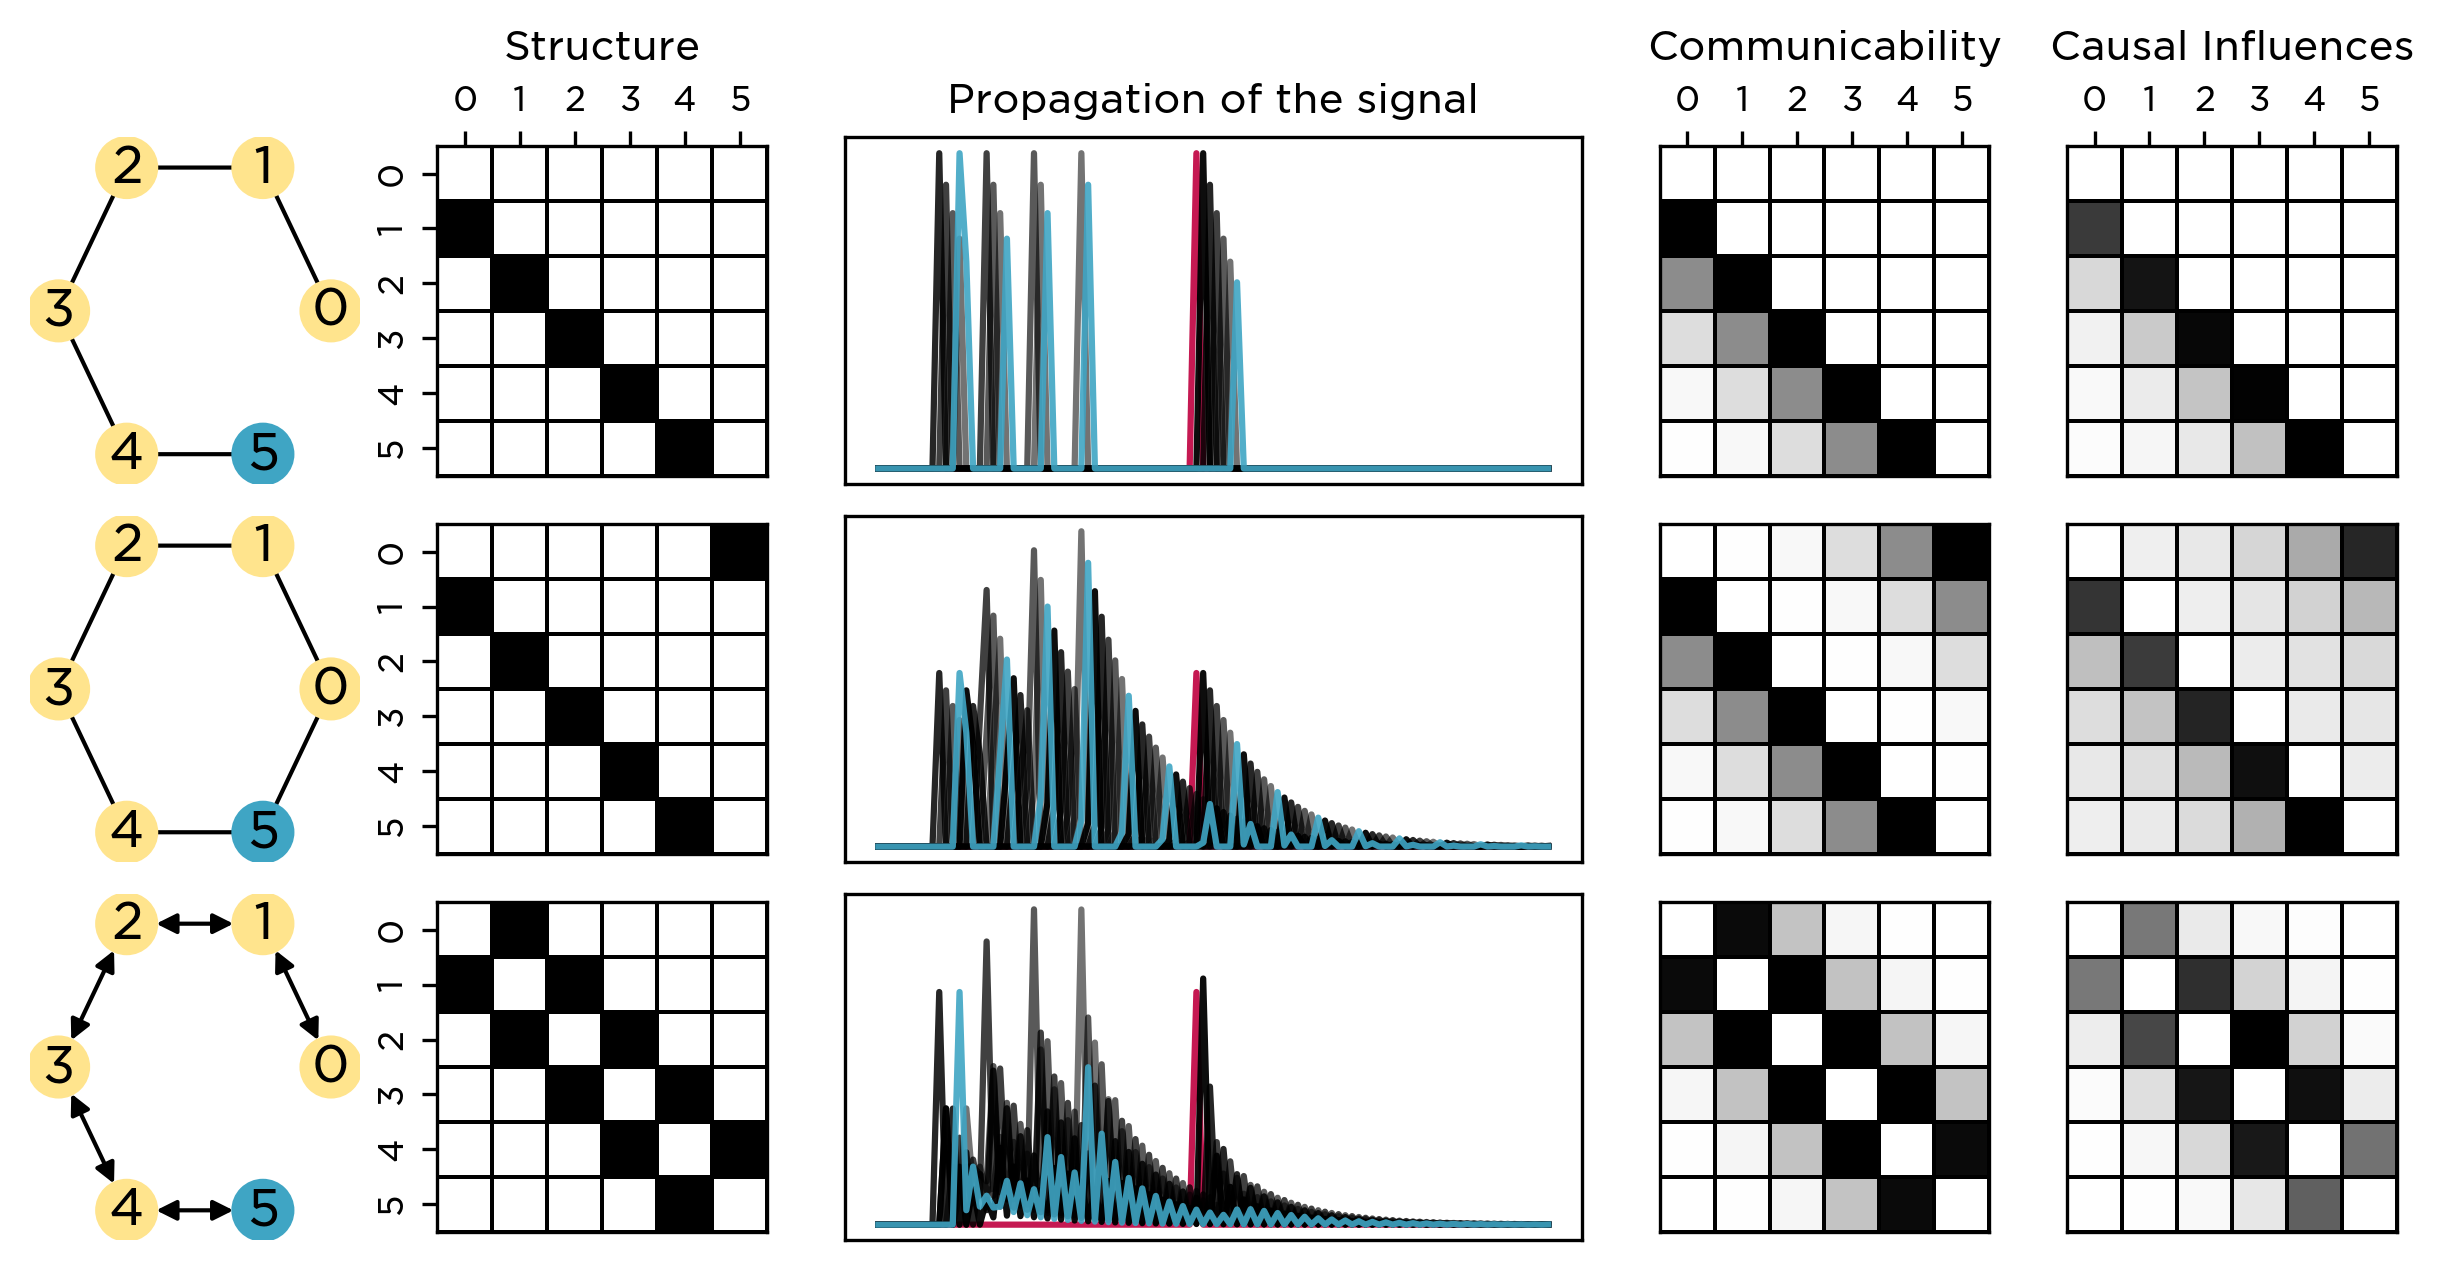

In [425]:
# fig,axes = plt.subplot_mosaic([['X','CX','CIX','B', 'B','A'],
#                                ['Y','CY','CIY','D', 'D','C'],
#                                ['Z','CZ','CIZ','F', 'F','E']],figsize=(8,4.2),dpi=300)

fig,axes = plt.subplot_mosaic([['A','X','B', 'B','CX','CIX'],
                               ['C','Y','D', 'D','CY','CIY'],
                               ['E','Z','F', 'F','CZ','CIZ']],figsize=(8,4.2),dpi=300)

#===================================== STRUCTURE
sns.heatmap(chain,
            square=True,
            cmap='binary',cbar=False,ax=axes['X'],linewidths=0.5, linecolor='k')

sns.heatmap(closedchain,
            square=True,
            cmap='binary',cbar=False,ax=axes['Y'],linewidths=0.5, linecolor='k')

sns.heatmap(symmetricchain,
            square=True,
            cmap='binary',cbar=False,ax=axes['Z'],linewidths=0.5, linecolor='k')
#===================================== COMMUNICABILITY
sns.heatmap(cchain,
            square=True,
            cmap='binary',cbar=False,ax=axes['CX'],linewidths=0.5, linecolor='k')

sns.heatmap(ccchain,
            square=True,
            cmap='binary',cbar=False,ax=axes['CY'],linewidths=0.5, linecolor='k')

sns.heatmap(csychain,
            square=True,
            cmap='binary',cbar=False,ax=axes['CZ'],linewidths=0.5, linecolor='k')
#===================================== CAUSAL INFLUENCE - COMMUNICABILITY
sns.heatmap(ci_chain*chain_mask,
            square=True,
            cmap='binary',cbar=False,ax=axes['CIX'],linewidths=0.5, linecolor='k')

sns.heatmap(ci_closed_chain*closedchain_mask,
            square=True,
            cmap='binary',cbar=False,ax=axes['CIY'],linewidths=0.5, linecolor='k')

sns.heatmap(ci_symmetric_chain*symmetricchain_mask,
            square=True,
            cmap='binary',cbar=False,ax=axes['CIZ'],linewidths=0.5, linecolor='k')


node_colors=['#FFE48D','#FFE48D','#FFE48D','#FFE48D','#FFE48D','#3FA5C4']
nx.draw_circular(nx.from_numpy_array(chain),ax=axes['A'],
                 arrows=True,node_size=200,node_color=node_colors,with_labels=True)
nx.draw_circular(nx.from_numpy_array(closedchain),ax=axes['C'],
                 arrows=True,node_size=200,node_color=node_colors,with_labels=True)
nx.draw_circular(nx.from_numpy_array(symmetricchain),ax=axes['E'],
                 arrows=True,node_size=200,node_color=node_colors,arrowstyle='<|-|>',with_labels=True)
for ax in ['B','D','F']:
    axes[ax].plot(example_input[0],c=my_colors[-1],alpha=0.9)

    axes[ax].yaxis.set_visible(False)

for ax in ['B','C','D','Y','Z']:
    axes[ax].xaxis.set_visible(False)
for i in range(len(chain)):
    if i < len(chain)-1:
        axes['B'].plot(simple_chain_dynamics.T[:,i],c='k',alpha=1-((i/10)+0.05))
    else:
        axes['B'].plot(simple_chain_dynamics.T[:,i],c=my_colors[1],alpha=(0.9))

for i in range(len(chain)):
    if i < len(chain)-1:
        axes['D'].plot(closed_chain_dynamics.T[:,i],c='k',alpha=1-((i/10)+0.05))
    else:
        axes['D'].plot(closed_chain_dynamics.T[:,i],c=my_colors[1],alpha=(0.9))

for i in range(len(chain)):
        if i < len(chain)-1:
            axes['F'].plot(symmetric_chain_dynamics.T[:,i],c='k',alpha=1-((i/10)+0.05))
        else:
            axes['F'].plot(symmetric_chain_dynamics.T[:,i],c=my_colors[1],alpha=(0.9))

axes['B'].title.set_text('Propagation of the signal')
axes['X'].title.set_text('Structure')
axes['CX'].title.set_text('Communicability')
axes['CIX'].title.set_text('Causal Influences')

axes['B'].yaxis.tick_right()

for ax in ['X','CX','CIX']:
    axes[ax].xaxis.tick_top()
for ax in ['CY','CZ','CIY','CIZ','F']:
    axes[ax].xaxis.set_visible(False)

for ax in ['CX','CY','CZ','CIX','CIY','CIZ']:
    axes[ax].yaxis.set_visible(False)

for ax in axes:
    axes[ax].spines['right'].set_visible(True)
    axes[ax].spines['top'].set_visible(True)
    axes[ax].spines['bottom'].set_visible(True)
    axes[ax].spines['left'].set_visible(True)
fig.tight_layout(pad=0.5)

#plt.savefig(f"chain_propagation.pdf",dpi=600,bbox_inches='tight')

In [426]:
netneurotools.datasets.available_connectomes()

['celegans',
 'drosophila',
 'human_func_scale033',
 'human_func_scale060',
 'human_func_scale125',
 'human_func_scale250',
 'human_func_scale500',
 'human_struct_scale033',
 'human_struct_scale060',
 'human_struct_scale125',
 'human_struct_scale250',
 'human_struct_scale500',
 'macaque_markov',
 'macaque_modha',
 'mouse',
 'rat']

In [427]:
human = netneurotools.datasets.fetch_connectome('human_struct_scale125')

In [428]:
connectivity = spectral_normalization(0.9,human['conn'])
n_neurons = len(connectivity)
communication_mask = np.where(communicability_wei(connectivity)!=0,1,0)
chuman = normer(communicability_wei(connectivity))


In [429]:
rng = np.random.default_rng(seed=SEED)
timesteps = 100
noise_strength = 0.5
# careers = [np.sin(np.linspace(1,i,timesteps)).squeeze() for i in range(n_neurons)]
# input = np.array(careers) *0.1

noise = rng.normal(0,noise_strength,(n_neurons,timesteps))

#input = event_maker(len(connectivity),timesteps)
input = noise
simple_human_dynamics = simple_linear_dynamical_system(connectivity,input)

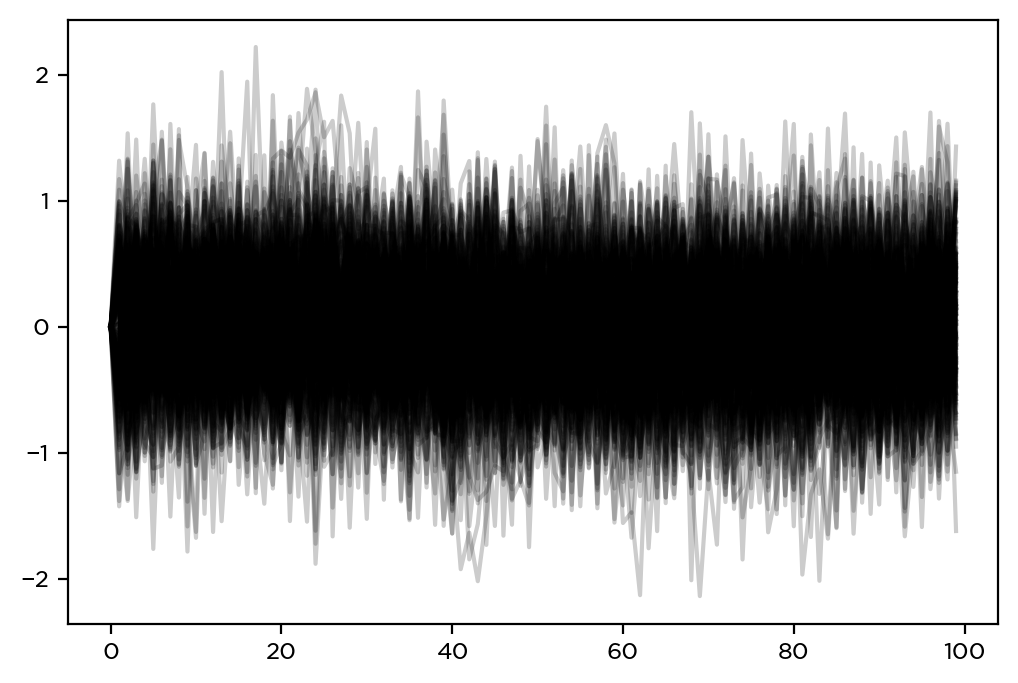

In [430]:
plt.figure(dpi=200)
plt.plot(simple_human_dynamics.T,alpha=0.2,color='k');

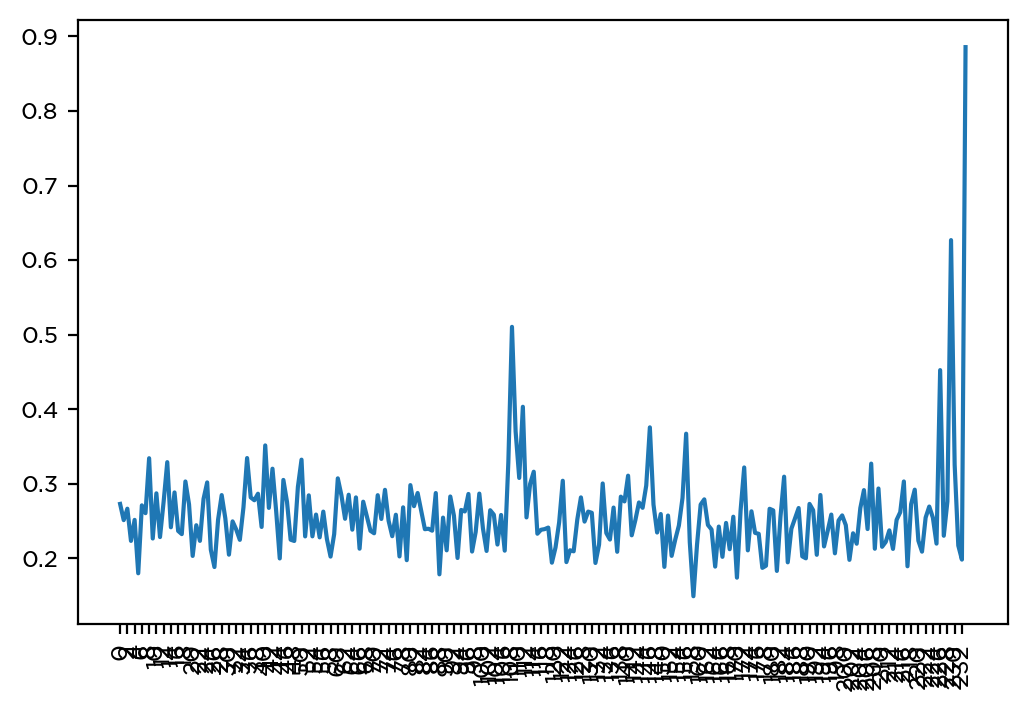

In [431]:
plt.figure(dpi=200)
plt.plot(simple_human_dynamics.var(axis=1))
plt.xticks(np.arange(0,len(connectivity),2),rotation=90);

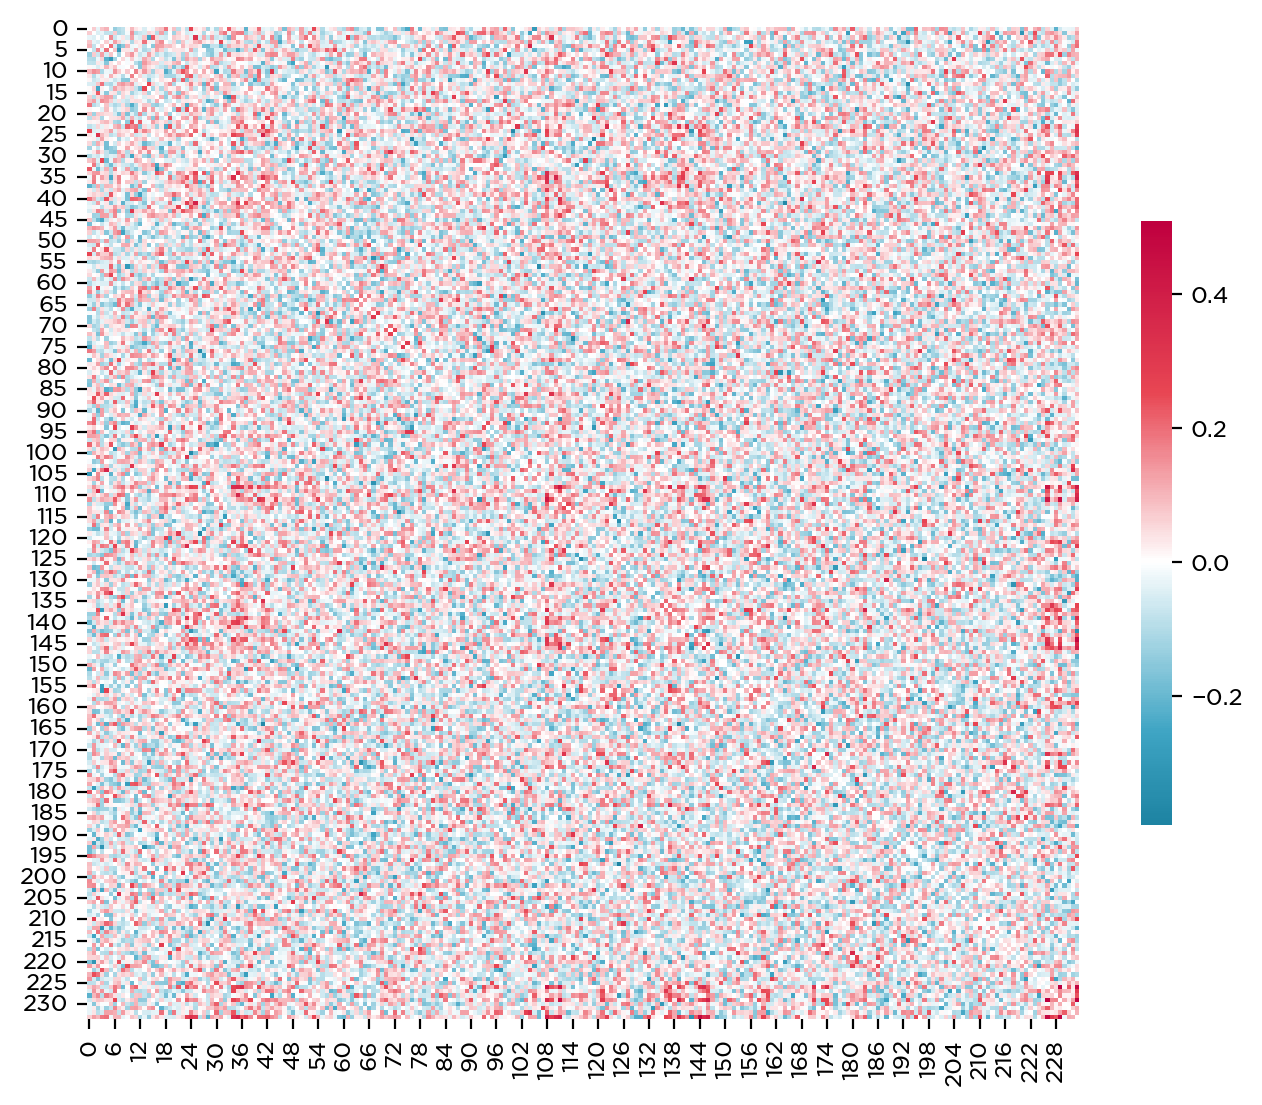

In [432]:
plt.figure(figsize=(8,8),dpi=200)
fc = np.corrcoef(simple_human_dynamics)
np.fill_diagonal(fc,0.)
sns.heatmap(fc,square=True,center=0,
            cmap=colormap,cbar_kws={"shrink": .5},linewidths=0., linecolor='k');

In [ ]:
lesion_params = {'network': connectivity, 'input': input}
ci_mat = msa.estimate_causal_influences(elements=list(range(n_neurons)),
                                        objective_function=lesion_simple_nodes,
                                        objective_function_params=lesion_params,
                                        n_permutations=1_000, n_cores=-1,parallelize_over_games=True)


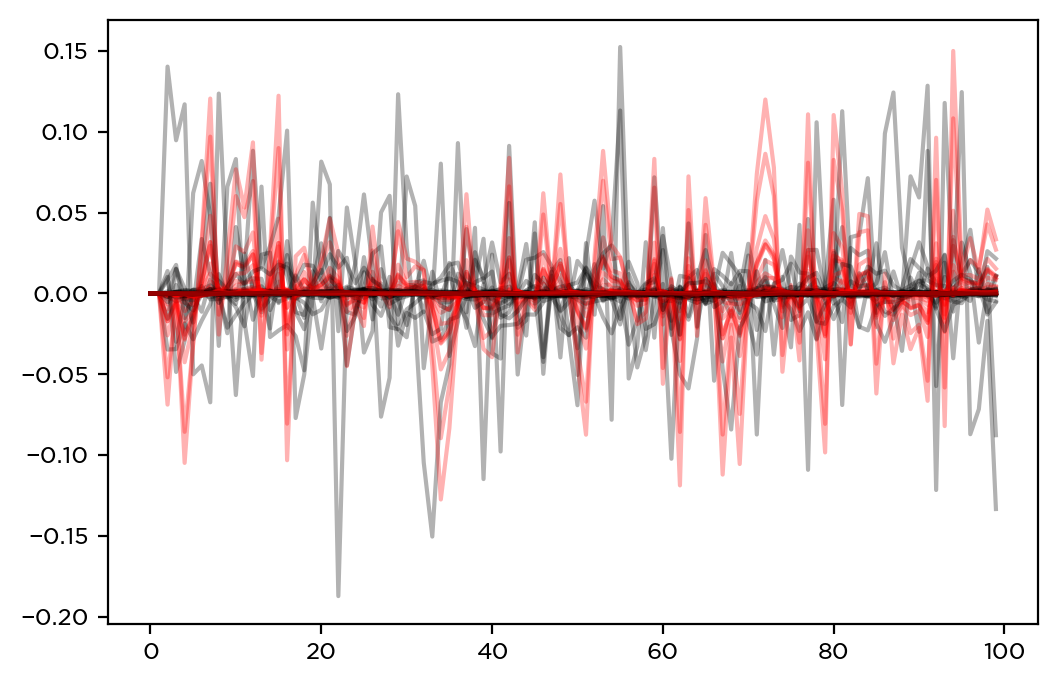

In [286]:
plt.figure(dpi=200)
for i in range(n_neurons):
    plt.plot(ci_mat[i][1],'k',alpha=0.3) # influence on the node
    plt.plot(ci_mat[1][i],'r',alpha=0.3) # influenced by the node

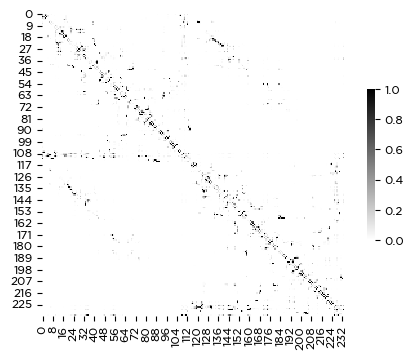

In [335]:
ci_mate = ci_mat.groupby(level=0).var().fillna(0)

In [217]:
normalized_ci = normer(ci_mate*communication_mask)
diff = normalized_ci - chuman
diff = threshold(1,diff)


In [346]:
boths_outgoing = make_influence_ratio(diff)
boths_incoming = make_influence_ratio(diff,axis=1)

/home/kayson/anaconda3/envs/cmodes/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:>

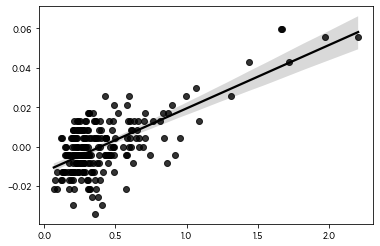

In [443]:
sns.regplot(connectivity.sum(axis=1),boths_incoming,color='k')


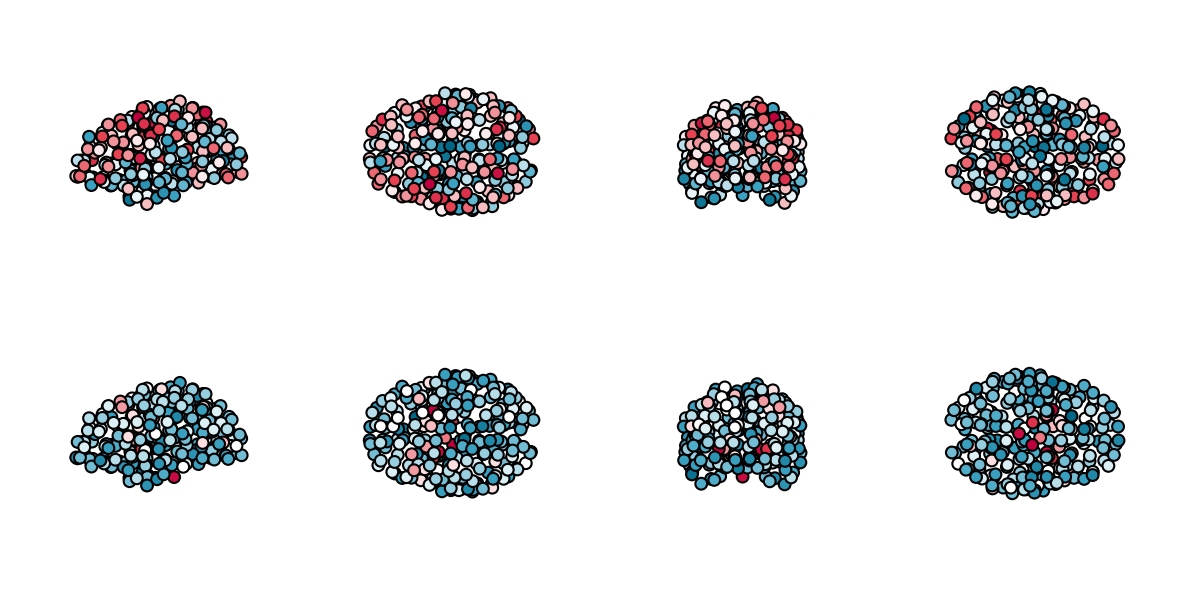

In [370]:
scatter_kw = dict(alpha=1,linewidth=0.5, edgecolor='k')
size=8
fig,axes = plt.subplot_mosaic([['A','B','C','D'],
                               ['E','F','G','H']],figsize=(4,2),subplot_kw=dict(projection='3d'),dpi=300)
brain_plotter(boths_outgoing,human['coords'],axes['A'],view=sagittal,size=size,cmap=colormap,scatter_kwargs=scatter_kw)
brain_plotter(boths_outgoing,human['coords'],axes['B'],view=axial,size=size,cmap=colormap,scatter_kwargs=scatter_kw)
brain_plotter(boths_outgoing,human['coords'],axes['C'],view=coronal,size=size,cmap=colormap,scatter_kwargs=scatter_kw)
brain_plotter(boths_outgoing,human['coords'],axes['D'],view=bottom,size=size,cmap=colormap,scatter_kwargs=scatter_kw)

brain_plotter(boths_incoming,human['coords'],axes['E'],view=sagittal,size=size,cmap=colormap,scatter_kwargs=scatter_kw)
brain_plotter(boths_incoming,human['coords'],axes['F'],view=axial,size=size,cmap=colormap,scatter_kwargs=scatter_kw)
brain_plotter(boths_incoming,human['coords'],axes['G'],view=coronal,size=size,cmap=colormap,scatter_kwargs=scatter_kw)
brain_plotter(boths_incoming,human['coords'],axes['H'],view=bottom,size=size,cmap=colormap,scatter_kwargs=scatter_kw)
fig.tight_layout(pad=1)

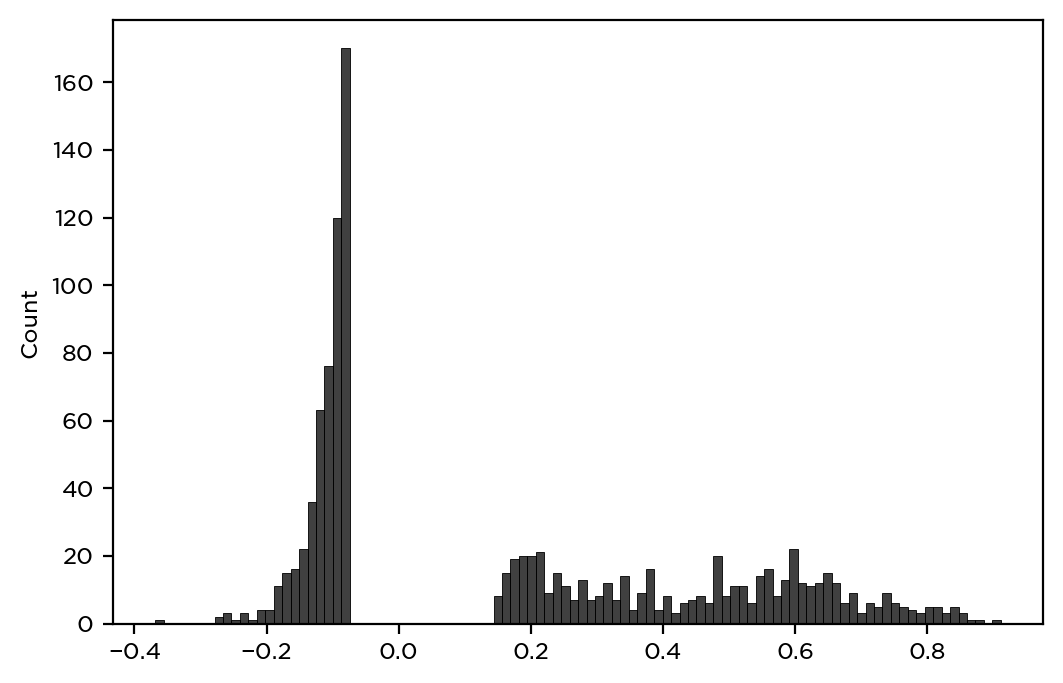

In [360]:
plt.figure(dpi=200)
sns.histplot(diff.values.flatten()[diff.values.flatten()!=0.],bins=100,color='k');
#

In [209]:
log_ci = np.abs(np.nan_to_num(np.log(normalized_ci),neginf=0))
log_comm = np.abs(np.nan_to_num(np.log(chuman),neginf=0))
log_sc = np.abs(np.nan_to_num(np.log(normer(connectivity)),neginf=0))

/tmp/ipykernel_9311/227954366.py:2: RuntimeWarning: divide by zero encountered in log
  log_comm = np.abs(np.nan_to_num(np.log(chuman),neginf=0))
/tmp/ipykernel_9311/227954366.py:3: RuntimeWarning: divide by zero encountered in log
  log_sc = np.abs(np.nan_to_num(np.log(normer(connectivity)),neginf=0))


/tmp/ipykernel_9311/2262069988.py:28: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout(pad=1)


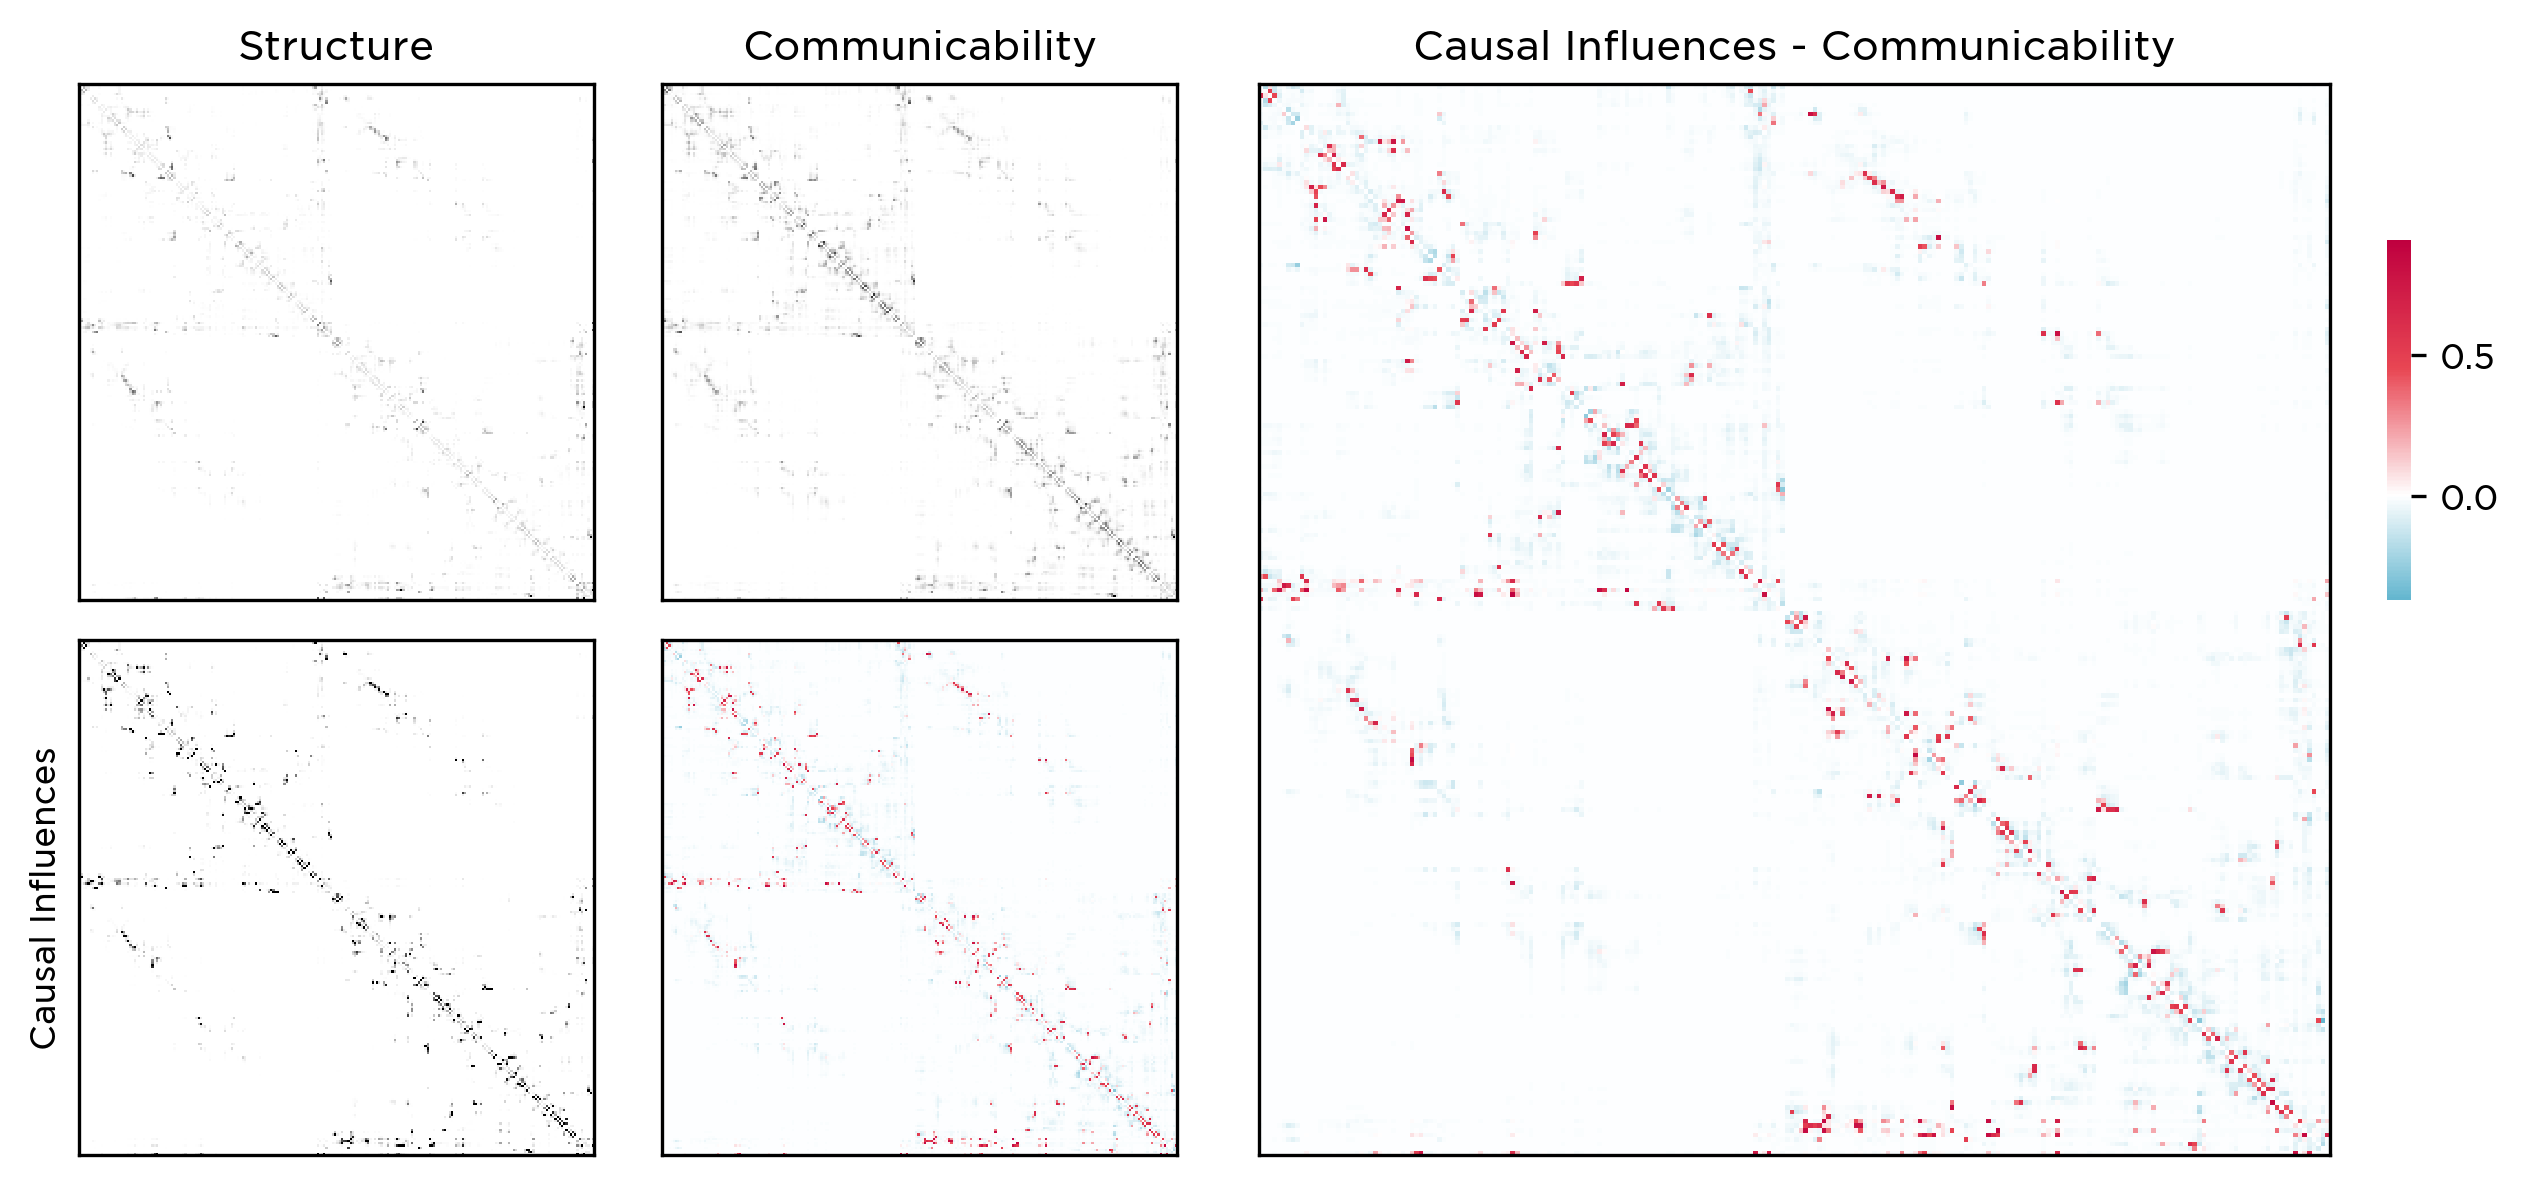

In [369]:
fig,axes = plt.subplot_mosaic([['A','CA','Z','Z'],
                               ['CI','DI','Z','Z']],figsize=(8,4),dpi=300)
cbar_ax = fig.add_axes([1, .5, .01, .3])

sns.heatmap(normer(connectivity),square=True,xticklabels=False,yticklabels=False,
            cmap='binary',cbar=False,ax=axes['A'],linewidths=0, linecolor='k')
sns.heatmap(chuman,square=True,xticklabels=False,yticklabels=False,
            cmap='binary',cbar=False,ax=axes['CA'],linewidths=0, linecolor='k')

sns.heatmap(normalized_ci*communication_mask,square=True,xticklabels=False,yticklabels=False,
            cmap='binary',cbar=False,ax=axes['CI'],linewidths=0, linecolor='k')
sns.heatmap((normalized_ci - chuman),square=True,xticklabels=False,yticklabels=False,center=0,
            cmap=colormap,cbar=False,ax=axes['DI'],linewidths=0, linecolor='k')
sns.heatmap((normalized_ci - chuman),square=True,xticklabels=False,yticklabels=False,center=0,
            cmap=colormap,cbar_ax=cbar_ax,ax=axes['Z'],linewidths=0.0)
for ax in axes:
    axes[ax].spines['right'].set_visible(True)
    axes[ax].spines['top'].set_visible(True)
    axes[ax].spines['bottom'].set_visible(True)
    axes[ax].spines['left'].set_visible(True)

#axes['B'].title.set_text('Propagation of the signal through the human connectome')
axes['A'].title.set_text('Structure')
axes['CA'].title.set_text('Communicability')
axes['Z'].title.set_text('Causal Influences - Communicability')
axes['CI'].set_ylabel("Causal Influences")

fig.tight_layout(pad=1)
#plt.savefig(f"human_propagation.pdf",dpi=600,bbox_inches='tight')

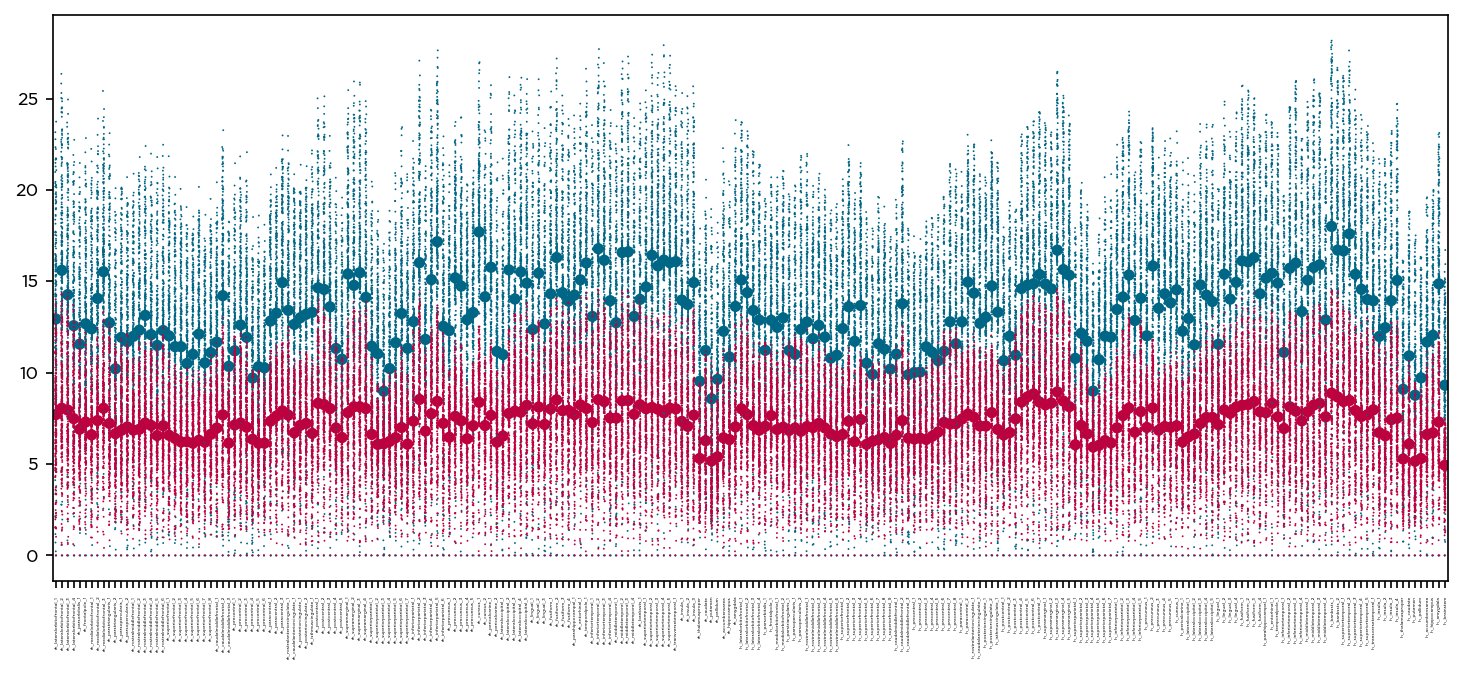

In [371]:
plt.figure(figsize=(12,5),dpi=150)
sns.pointplot(data=log_ci,color=my_colors[0],label='Causal Influence',join=False,markers='.',errwidth=0.8) #red
sns.pointplot(data=log_comm,color=my_colors[-1],label='Communicability',join=False,markers='.',errwidth=0.8)

sns.stripplot(data=log_ci,color=my_colors[0],label='Causal Influence',size=0.9) #red
sns.stripplot(data=log_comm,color=my_colors[-1],label='Communicability',size=0.9)
#plt.legend(frameon=False)
plt.xticks(ticks = [i for i,_ in enumerate(human.labels)],labels=human.labels,rotation=90,fontsize=2);

<AxesSubplot:>

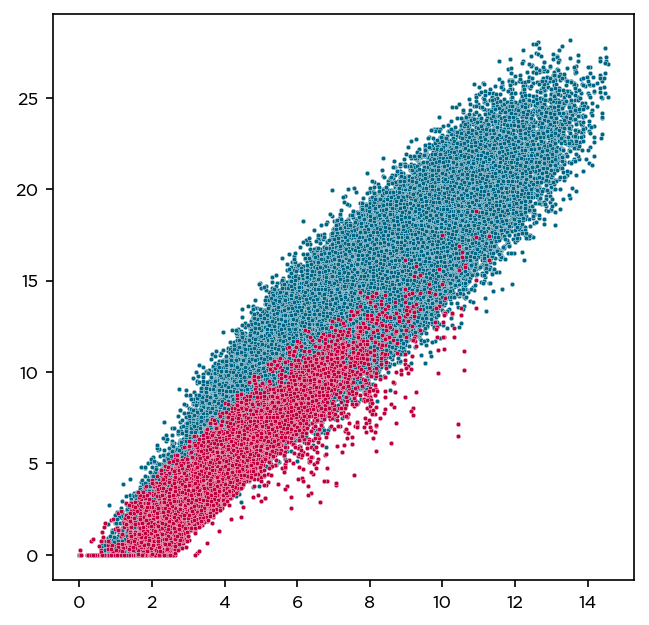

In [373]:
plt.figure(figsize=(5,5),dpi=150)
sns.scatterplot(x=log_comm.flatten(),y=log_ci.flatten(),color=my_colors[0],s=5)
sns.scatterplot(x=log_sc.flatten()[log_sc.flatten()!=0],y=log_ci.flatten()[log_sc.flatten()!=0],color=my_colors[-1],s=5)
#sns.lineplot(x=log_comm.flatten(), y=log_comm.flatten(), color='k', linestyle='--')


In [363]:
human.keys()

dict_keys(['conn', 'coords', 'dist', 'labels', 'ref'])

<AxesSubplot:>

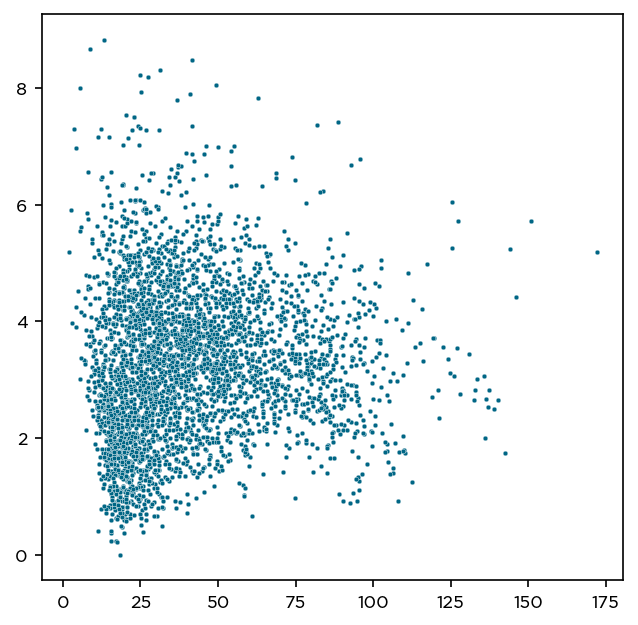

In [212]:
plt.figure(figsize=(5,5),dpi=150)
sns.scatterplot(x=human['dist'].flatten()[human['dist'].flatten()!=0],y=log_comm.flatten()[human['dist'].flatten()!=0],color=my_colors[0],s=5)

In [335]:
input_events = event_maker(len(connectivity),timesteps,probability=1)
simple_human_dynamics_events = simple_linear_dynamical_system(connectivity,input_events)

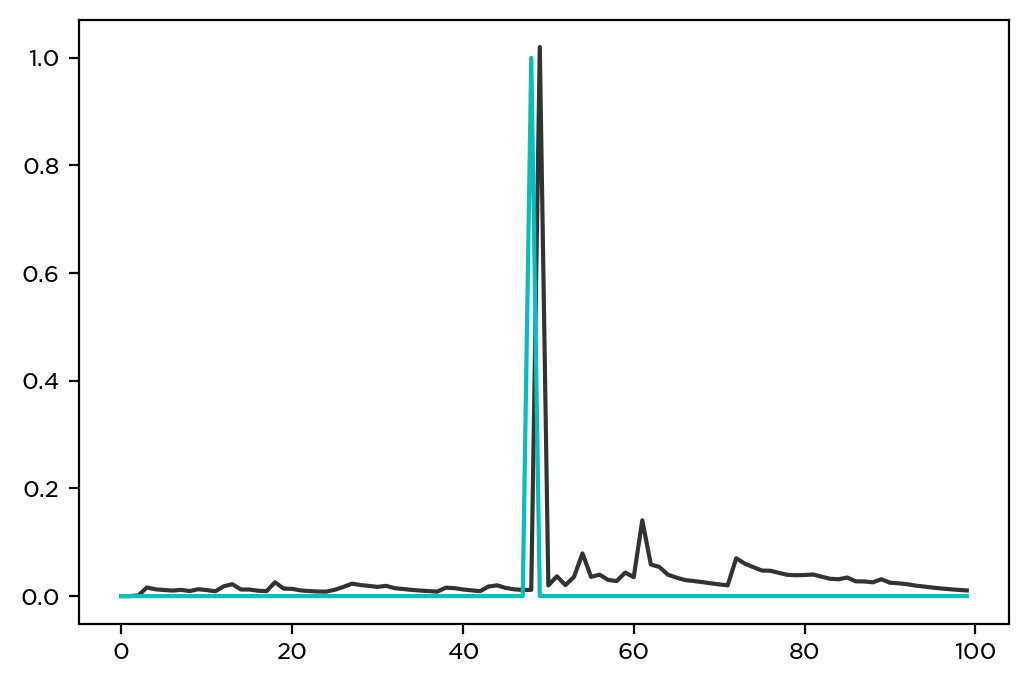

In [340]:
plt.figure(dpi=200)
plt.plot(simple_human_dynamics_events[4],alpha=0.8,color='k')
plt.plot(input_events[4],color='c');

In [ ]:
lesion_params = {'network': connectivity, 'input': input_events}
ci_mat_events = msa.estimate_causal_influences(elements=list(range(n_neurons)),
                                        objective_function=lesion_simple_nodes,
                                        objective_function_params=lesion_params,
                                        n_permutations=1_000, n_cores=-1,parallelize_over_games=True)

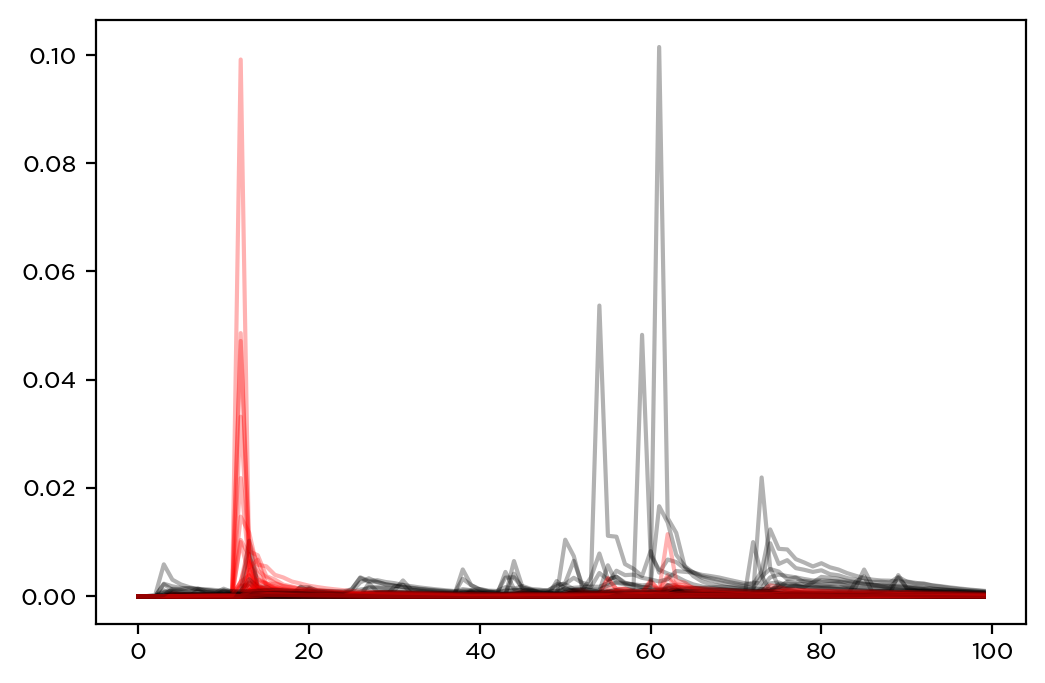

In [342]:
plt.figure(dpi=200)
for i in range(n_neurons):
    plt.plot(ci_mat_events[i][1],'k',alpha=0.3) # influence on the node
    plt.plot(ci_mat_events[1][i],'r',alpha=0.3) # influenced by the node

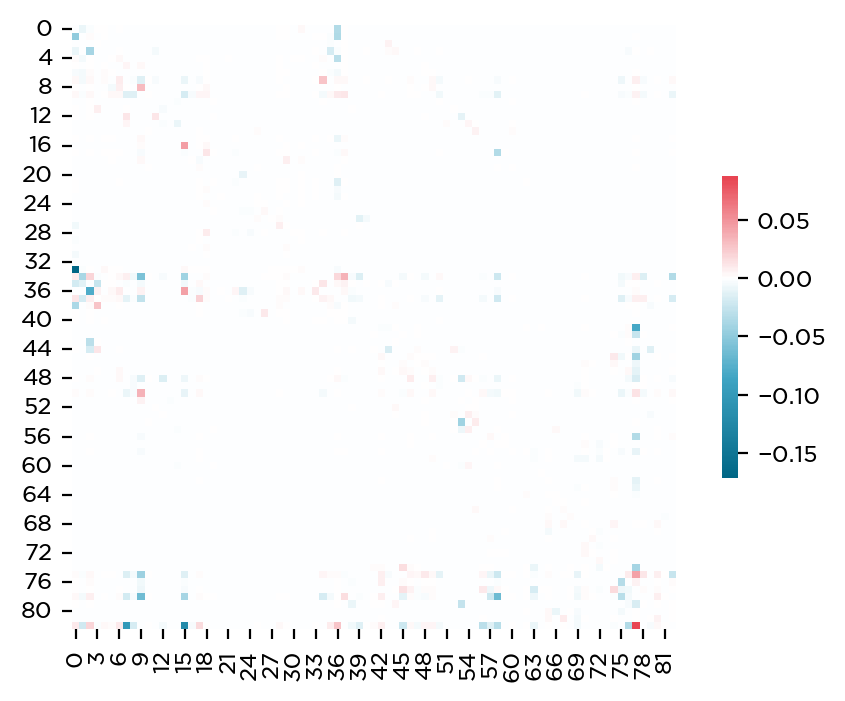

In [343]:
ci_mate_events = ci_mat_events.groupby(level=0).var().fillna(0)
plt.figure(dpi=200)
sns.heatmap(normer(ci_mate_events)-normalized_ci,center=0,square=True,cmap=colormap,cbar_kws={"shrink": .5},linewidths=0., linecolor='k');

In [422]:
normalized_ci = normer(ci_mate_events*communication_mask)
diff = normalized_ci - chuman
diff = diff.fillna(0)
lower = np.percentile(diff, 5)
upper = np.percentile(diff, 95)
diff[(diff < upper) & (diff > lower)] = 0.0

log_ci = np.abs(np.nan_to_num(np.log(normalized_ci),neginf=0))


In [423]:
positives = diff[diff>0]
negatives = diff[diff<0]
positives.sum().sum()/negatives.sum().sum()

-2.8786190785985557

/tmp/ipykernel_11189/1895396242.py:53: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout(pad=1)


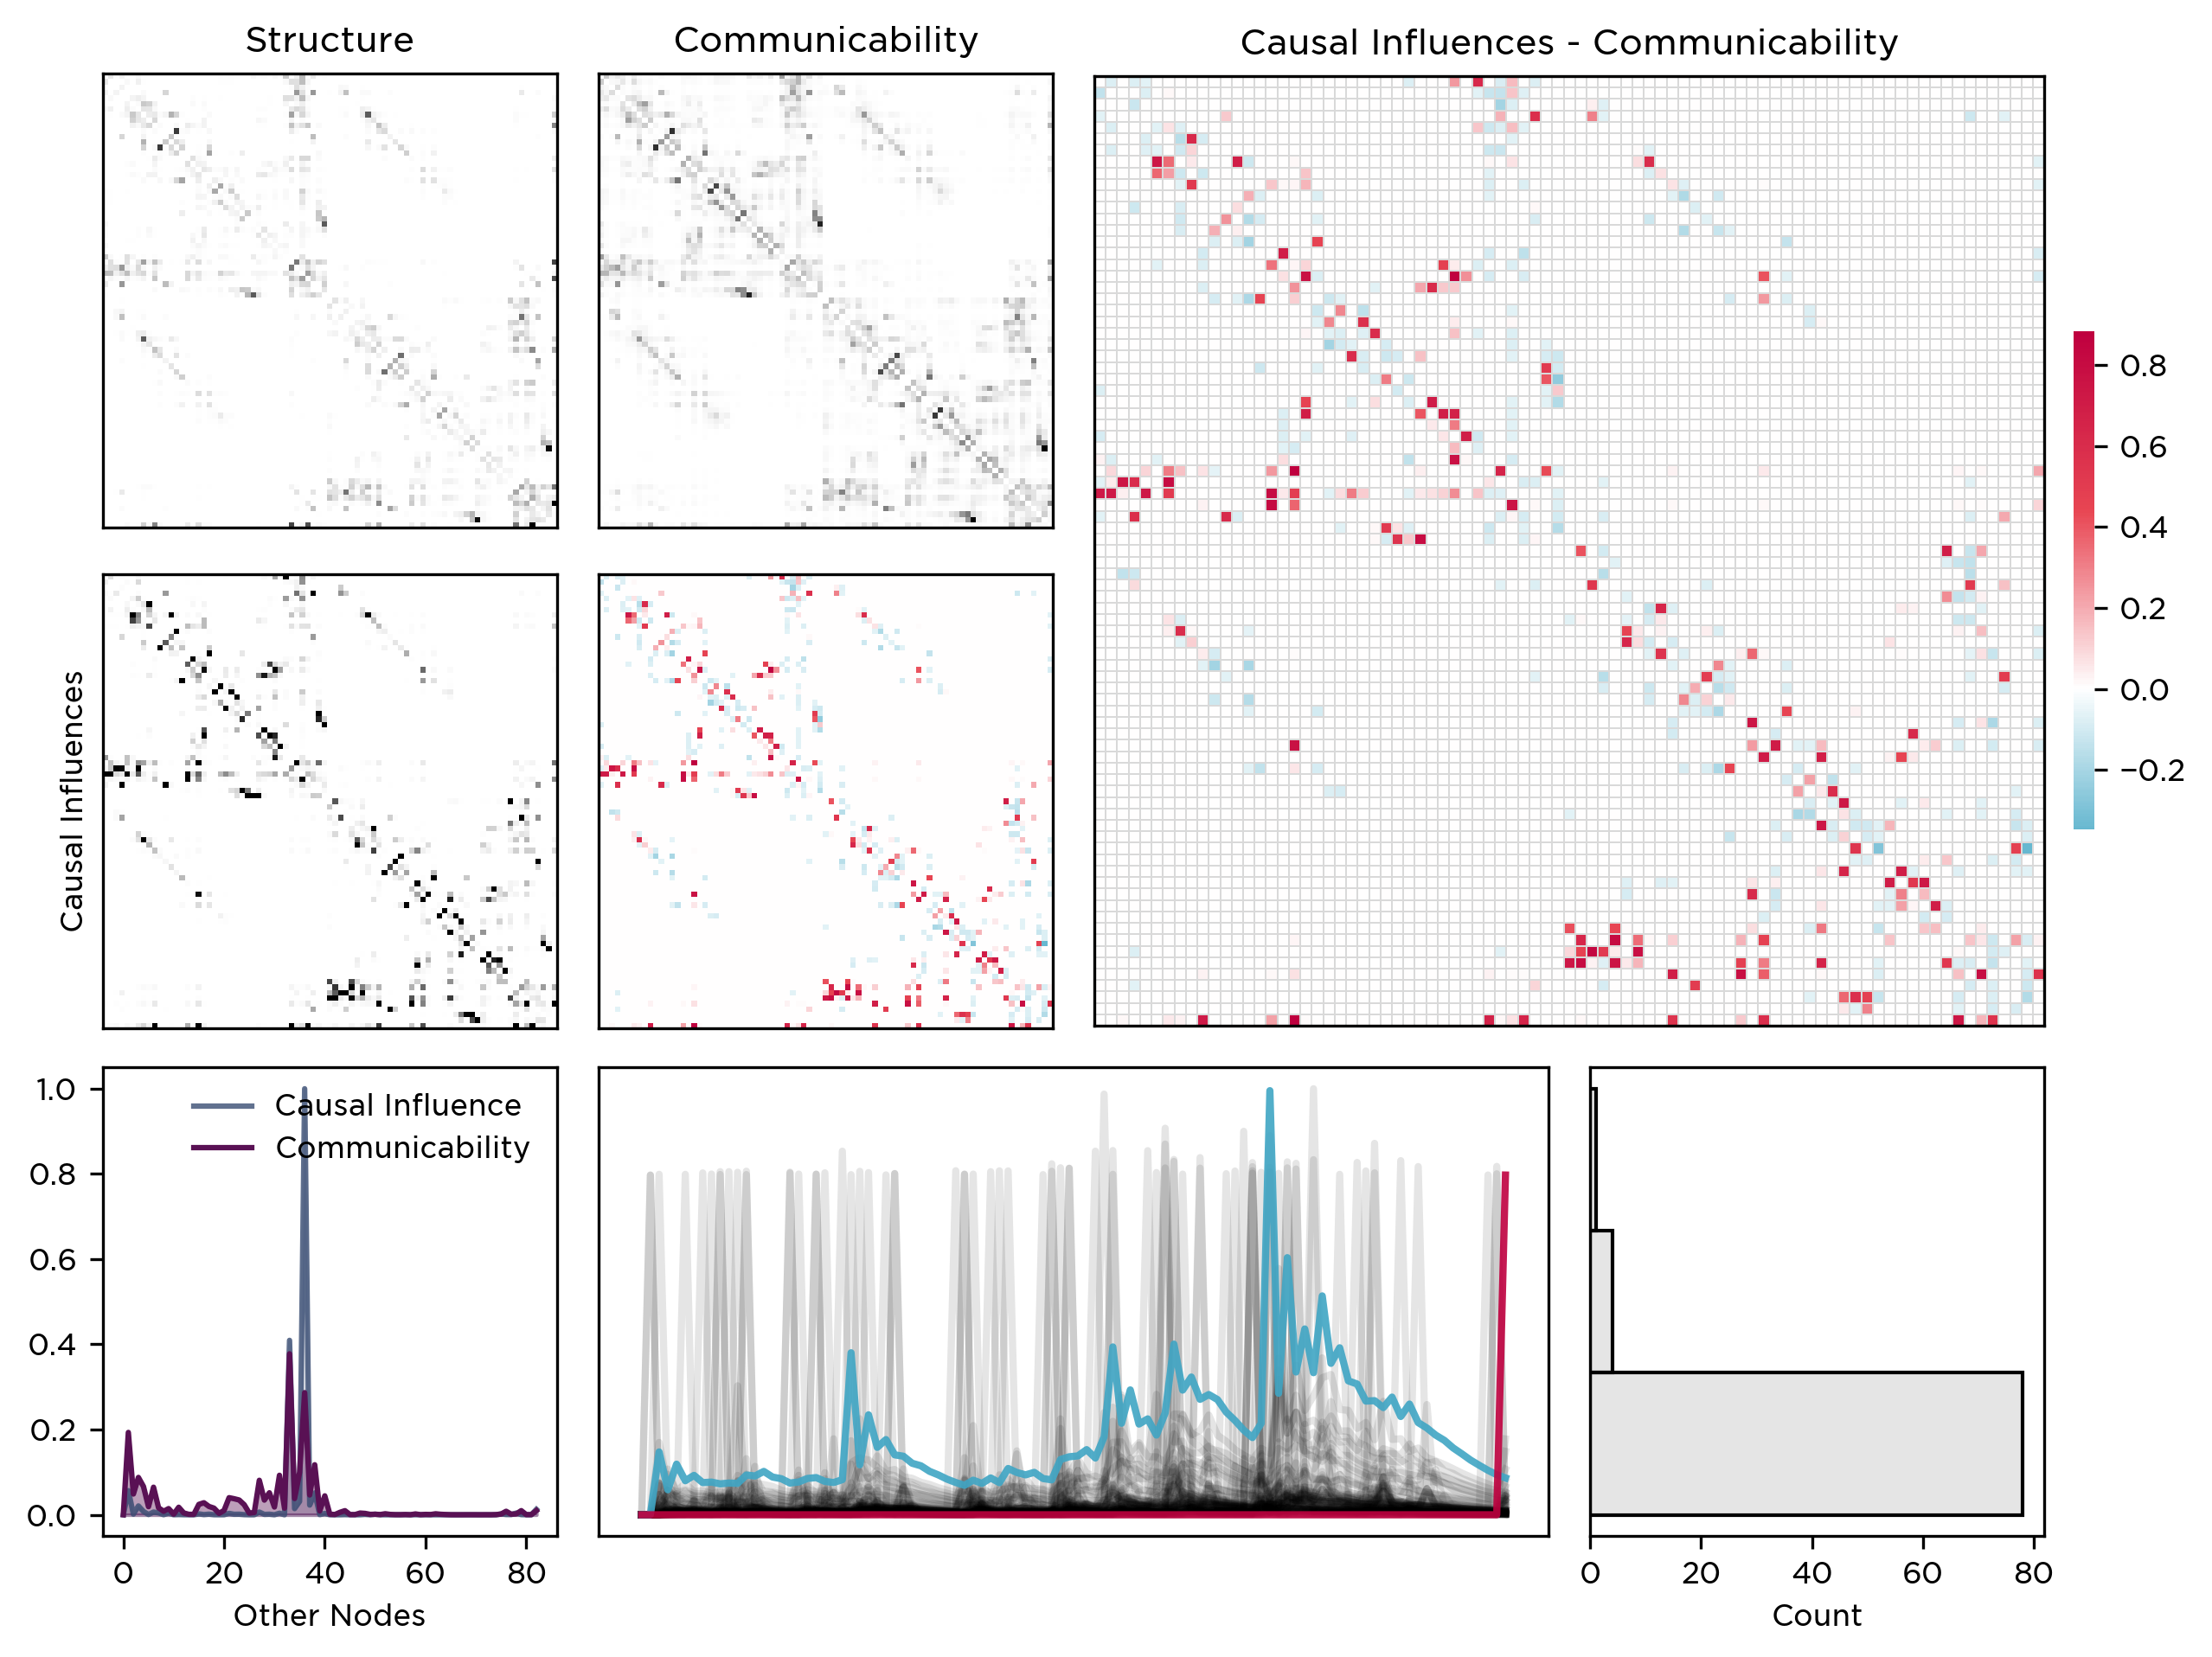

In [347]:
fig,axes = plt.subplot_mosaic([['A','CA','Z','Z'],
                               ['CI','DI','Z','Z'],
                                ['C','B','B','H']],figsize=(8,6.4),dpi=300)
cbar_ax = fig.add_axes([1, .5, .01, .3])

sns.heatmap(normer(connectivity),square=True,xticklabels=False,yticklabels=False,
            cmap='binary',cbar=False,ax=axes['A'],linewidths=0, linecolor='k')
sns.heatmap(chuman,square=True,xticklabels=False,yticklabels=False,
            cmap='binary',cbar=False,ax=axes['CA'],linewidths=0, linecolor='k')

sns.heatmap(normalized_ci,square=True,xticklabels=False,yticklabels=False,
            cmap='binary',cbar=False,ax=axes['CI'],linewidths=0, linecolor='k')
sns.heatmap(diff,square=True,xticklabels=False,yticklabels=False,center=0,
            cmap=colormap,cbar=False,ax=axes['DI'],linewidths=0, linecolor='k')
sns.heatmap(diff,square=True,xticklabels=False,yticklabels=False,center=0,
            cmap=colormap,cbar_ax=cbar_ax,ax=axes['Z'],linewidths=0.01, linecolor='#D9D9D9')
for ax in axes:
    axes[ax].spines['right'].set_visible(True)
    axes[ax].spines['top'].set_visible(True)
    axes[ax].spines['bottom'].set_visible(True)
    axes[ax].spines['left'].set_visible(True)

axes['B'].xaxis.set_visible(False)
for i in range(len(connectivity)):
    if i < len(connectivity)-1:
        axes['B'].plot(simple_human_dynamics_events.T[:,i],c='k',alpha=0.1,linewidth=2)
    else:
        axes['B'].plot(simple_human_dynamics_events.T[:,i],c=my_colors[1],alpha=(0.9),linewidth=2)
axes['B'].plot(input_events[0],c=my_colors[-1],alpha=0.9,linewidth=2)

sns.histplot(y=simple_human_dynamics_events.T[-1,:],ax=axes['H'],binwidth=0.1,fill=True,color='k',element="bars",alpha=0.1)
#sns.histplot(y=simple_human_dynamics.T[-1,:],ax=axes['H'],binwidth=0.1,fill=False,color='k',element="step")

axes['H'].yaxis.set_visible(False)
#axes['B'].title.set_text('Propagation of the signal through the human connectome')
axes['A'].title.set_text('Structure')
axes['CA'].title.set_text('Communicability')
axes['Z'].title.set_text('Causal Influences - Communicability')
axes['CI'].set_ylabel("Causal Influences")
axes['B'].yaxis.set_visible(False)


x = np.linspace(0, len(connectivity)-1, len(connectivity))

axes['C'].fill_between(x,normalized_ci[0].fillna(0),color='#394D73',alpha=0.2)
axes['C'].fill_between(x,chuman[:,0],color='#591154',alpha=0.4)
axes['C'].plot(normalized_ci[0].fillna(0),color='#394D73',label='Causal Influence',alpha=0.8)
axes['C'].plot(chuman[:,0],color='#591154',label='Communicability')

axes['C'].legend(frameon=False,markerscale=0.1)
#axes['C'].set_ylabel("Node 0")
axes['C'].set_xlabel("Other Nodes")
fig.tight_layout(pad=1)
#plt.savefig(f"human_propagation.pdf",dpi=600,bbox_inches='tight')

<AxesSubplot:>

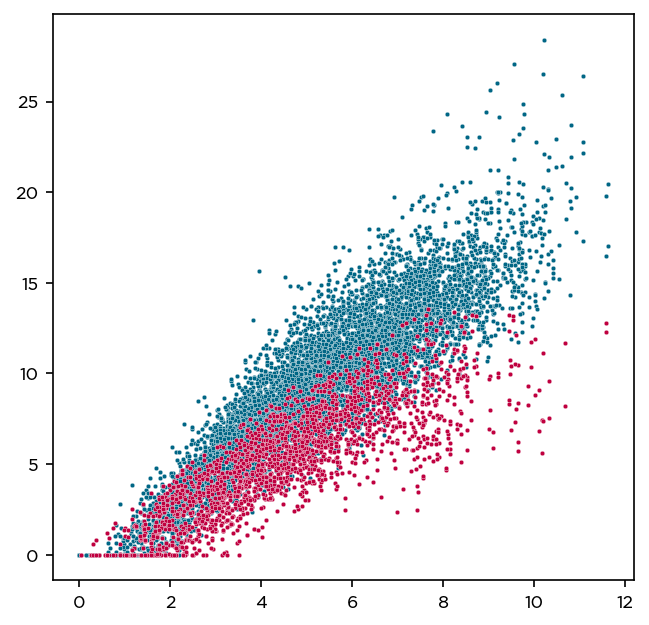

In [348]:
plt.figure(figsize=(5,5),dpi=150)
sns.scatterplot(x=log_comm.flatten(),y=log_ci.flatten(),color=my_colors[0],s=5)
sns.scatterplot(x=log_sc.flatten()[log_sc.flatten()!=0],y=log_ci.flatten()[log_sc.flatten()!=0],color=my_colors[-1],s=5)
#sns.lineplot(x=log_comm.flatten(), y=log_comm.flatten(), color='k', linestyle='--')


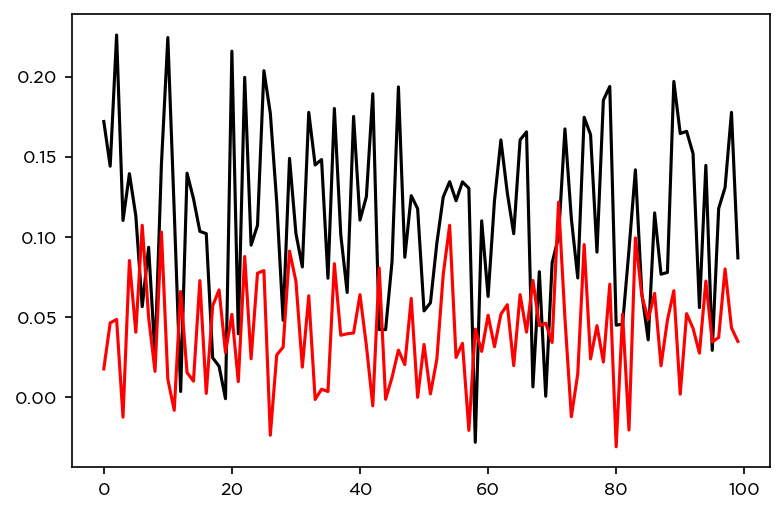

In [377]:
@njit
def wilson_cowan(x_e, x_i, W_ee, W_ei, W_ie, W_ii, theta_e, theta_i, tau_e, tau_i, dt, T):
    N = x_e.shape[0]
    ts = np.arange(0, T, dt)
    for t in ts:
        x_e_dot = -x_e/tau_e + np.tanh(W_ee @ x_e - W_ei @ x_i + theta_e)
        x_i_dot = -x_i/tau_i + np.tanh(W_ie @ x_e - W_ii @ x_i + theta_i)
        x_e += x_e_dot * dt
        x_i += x_i_dot * dt
    return x_e, x_i

# example parameters
N = 100
dt = 0.01
T = 100
theta_e = 0.3
theta_i = -0.7
tau_e = 2.0
tau_i = 1.0
W_ee = np.random.rand(N, N)*0.5
W_ei = np.random.rand(N, N)
W_ie = np.random.rand(N, N)
W_ii = np.random.rand(N, N)*0.5
# initial conditions
x_e = np.random.rand(N)
x_i = np.random.rand(N)
x_e_T, x_i_T = wilson_cowan(x_e, x_i, W_ee, W_ei, W_ie, W_ii, theta_e, theta_i, tau_e, tau_i, dt, T)

# plot the activity of the excitatory and inhibitory populations
plt.figure(dpi=150)
plt.plot(x_e_T,'k')
plt.plot(x_i_T,'r')